# Pipeline Analysis with PCA (all tasks features are kept together)

(We start with Random Forest but later test the same with the other three classifiers)

In this analysis, we aim to evaluate the performance of a Random Forest classifier on a dataset after applying Principal Component Analysis (PCA). The key steps and objectives are as follows:

1. **Data Loading and Preparation**:
   - We begin by loading the dataset using the `ucimlrepo` library and preprocess it by removing any non-feature columns (e.g., 'ID').

2. **Pipeline Setup**:
   - A machine learning pipeline is created that includes:
     - **StandardScaler**: To standardize the features, ensuring they have a mean of 0 and a standard deviation of 1.
     - **PCA**: To reduce dimensionality and capture a specified percentage of the total variance in the data. This helps in visualizing and improving model performance by removing noise and redundant features.
     - **RandomForestClassifier**: Method used for classification tasks. The classifier is configured with predefined hyperparameters for this analysis.

3. **Cross-Validation**:
   - We use K-Fold cross-validation (with `k=5`) to assess the performance of the pipeline. This involves splitting the dataset into training and test sets multiple times to ensure that our evaluation is reliable and not dependent on any single train-test split.

4. **PCA Variance Exploration**:
   - The PCA is performed with various thresholds of explained variance, ranging from 35% to 98%, to investigate how different levels of dimensionality reduction affect model performance.

5. **Performance Metrics**:
   - We evaluate the model using the following metrics:
     - **Accuracy**: Proportion of correctly classified instances.
     - **Precision**: Proportion of true positive predictions among all positive predictions.
     - **Recall (Sensitivity)**: Proportion of true positive predictions among all actual positive instances.
     - **F1 Score**: Harmonic mean of precision and recall, providing a single metric that balances the two.
     - **Specificity**: Proportion of true negative predictions among all actual negative instances.

6. **Results Visualization**:
   - The results are visualized through plots showing how each performance metric changes with different PCA explained variance thresholds. This helps in understanding the trade-offs between dimensionality reduction and model performance.

This analysis provides insights into the optimal amount of PCA explained variance for achieving the best performance from the Random Forest classifier and helps in making informed decisions about dimensionality reduction in machine learning pipelines.


In [61]:
# Import necessary libraries
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Drop the 'ID' column to avoid using it as a feature
X = X.drop(columns=['ID'])

# Flatten the target vector y to avoid DataConversionWarning
y = y.values.ravel()

# Define the number of splits for K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the PCA variance thresholds
pca_variances = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.98]

# Define the Random Forest parameters as specified
rf_params = {
    'bootstrap': True,
    'criterion': 'gini',
    'max_depth': 2,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 50,
    'random_state': 42  # Ensures reproducibility
}

# Dictionary to store mean scores for each PCA variance
results = {}

###########################################
# Get the total number of features
max_features = min(X.shape[0], X.shape[1])
###########################################

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Scorers for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),  # This is also sensitivity
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)  # Custom scorer for specificity
}

# Iterate over each PCA variance threshold
for variance in pca_variances:
    # Create a pipeline with StandardScaler, PCA, and RandomForestClassifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                  # Standardize the data
        ('pca', PCA(n_components=variance)),           # Apply PCA with specified variance
        ('classifier', RandomForestClassifier(**rf_params))  # Random Forest classifier
    ])
    
    # Perform cross-validation and compute multiple metrics
    cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, return_train_score=False)
    
    # Store the mean scores for each metric
    results[variance] = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'specificity': np.mean(cv_results['test_specificity'])
    }

    #################################################### 
    # Fit the PCA to get the number of components
    pca = PCA(n_components=variance)
    pca.fit(StandardScaler().fit_transform(X))
    n_components = pca.n_components_
    ####################################################
    
    # Print the results for the current PCA variance
    print(f"\nPCA with {variance*100:.0f}% explained variance:")
    print(f"  Components: {n_components}/{max_features}") 
    print(f"  Accuracy: {results[variance]['accuracy']:.4f}")
    print(f"  Precision: {results[variance]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {results[variance]['recall']:.4f}")
    print(f"  F1 Score: {results[variance]['f1']:.4f}")
    print(f"  Specificity: {results[variance]['specificity']:.4f}")


PCA with 35% explained variance:
  Components: 10/174
  Accuracy: 0.7751
  Precision: 0.8049
  Recall (Sensitivity): 0.7747
  F1 Score: 0.7800
  Specificity: 0.7825

PCA with 40% explained variance:
  Components: 12/174
  Accuracy: 0.7753
  Precision: 0.8210
  Recall (Sensitivity): 0.7387
  F1 Score: 0.7626
  Specificity: 0.8172

PCA with 45% explained variance:
  Components: 15/174
  Accuracy: 0.7758
  Precision: 0.8459
  Recall (Sensitivity): 0.7177
  F1 Score: 0.7537
  Specificity: 0.8381

PCA with 50% explained variance:
  Components: 19/174
  Accuracy: 0.7813
  Precision: 0.8013
  Recall (Sensitivity): 0.7904
  F1 Score: 0.7840
  Specificity: 0.7825

PCA with 55% explained variance:
  Components: 23/174
  Accuracy: 0.7699
  Precision: 0.7846
  Recall (Sensitivity): 0.7630
  F1 Score: 0.7679
  Specificity: 0.7811

PCA with 60% explained variance:
  Components: 28/174
  Accuracy: 0.8224
  Precision: 0.8498
  Recall (Sensitivity): 0.7872
  F1 Score: 0.8151
  Specificity: 0.8589

PCA

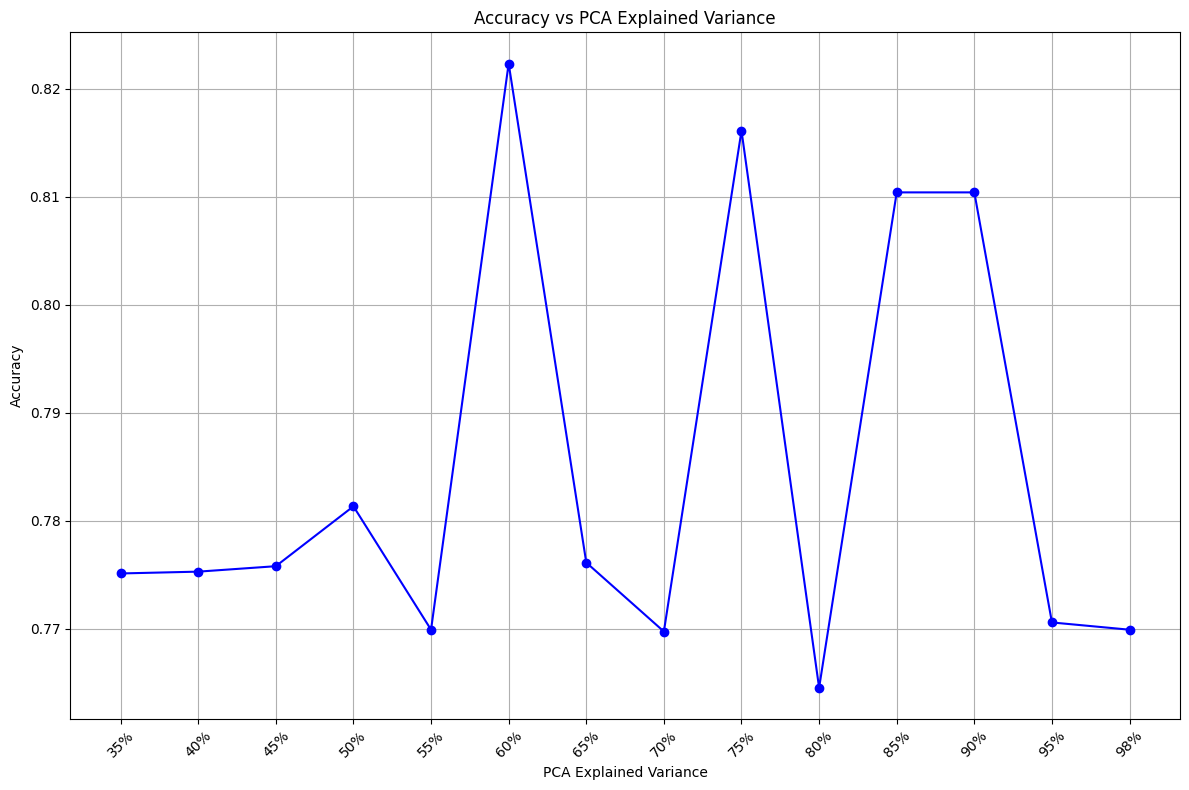

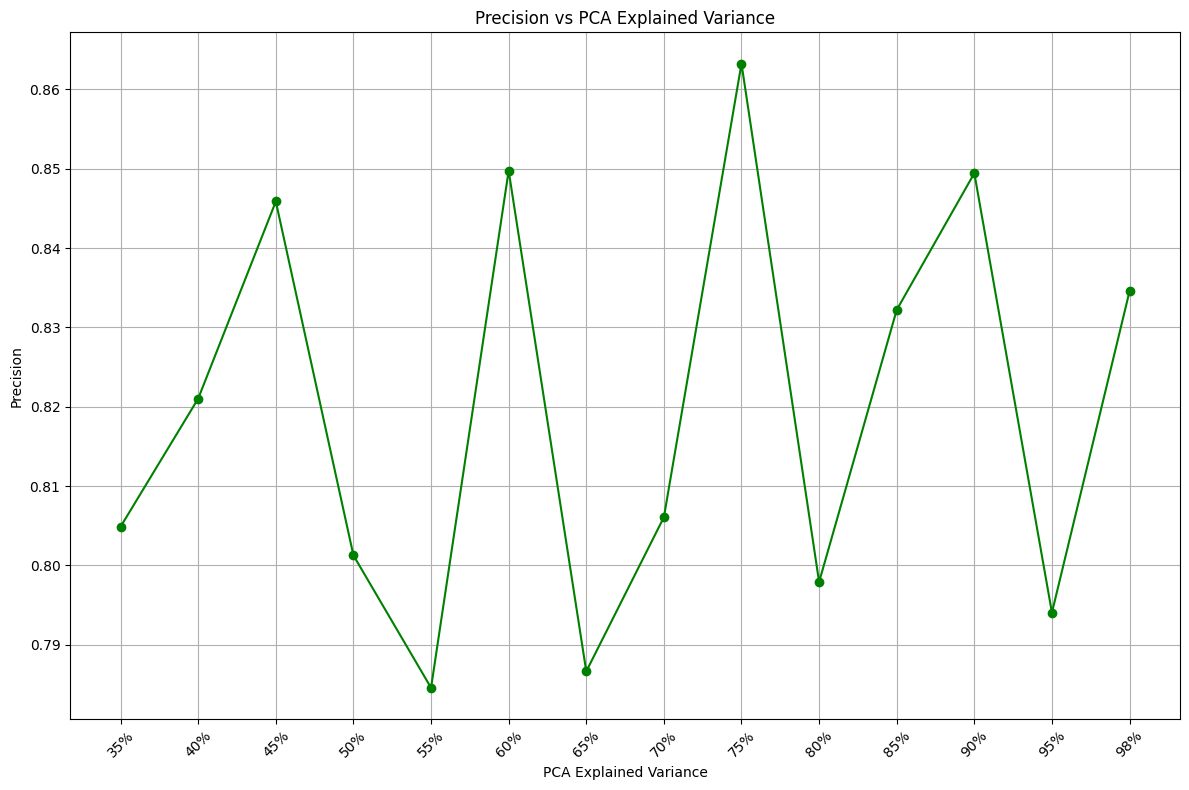

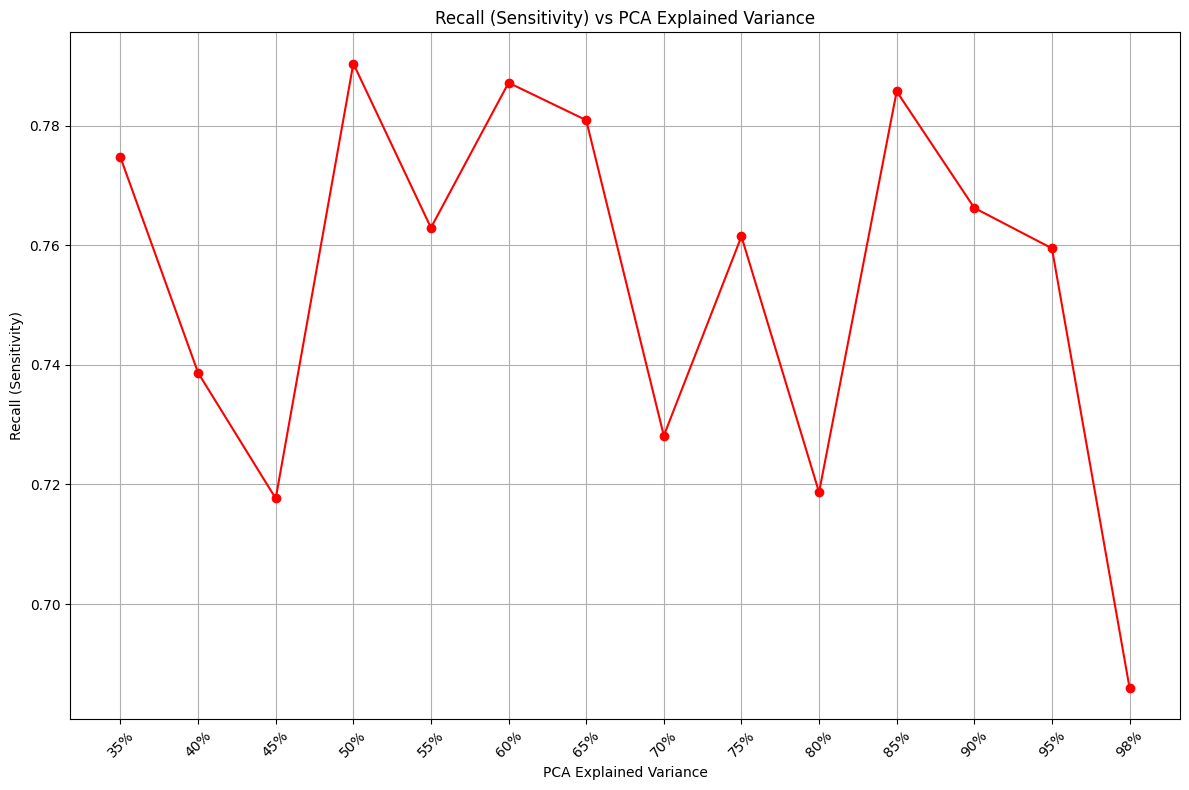

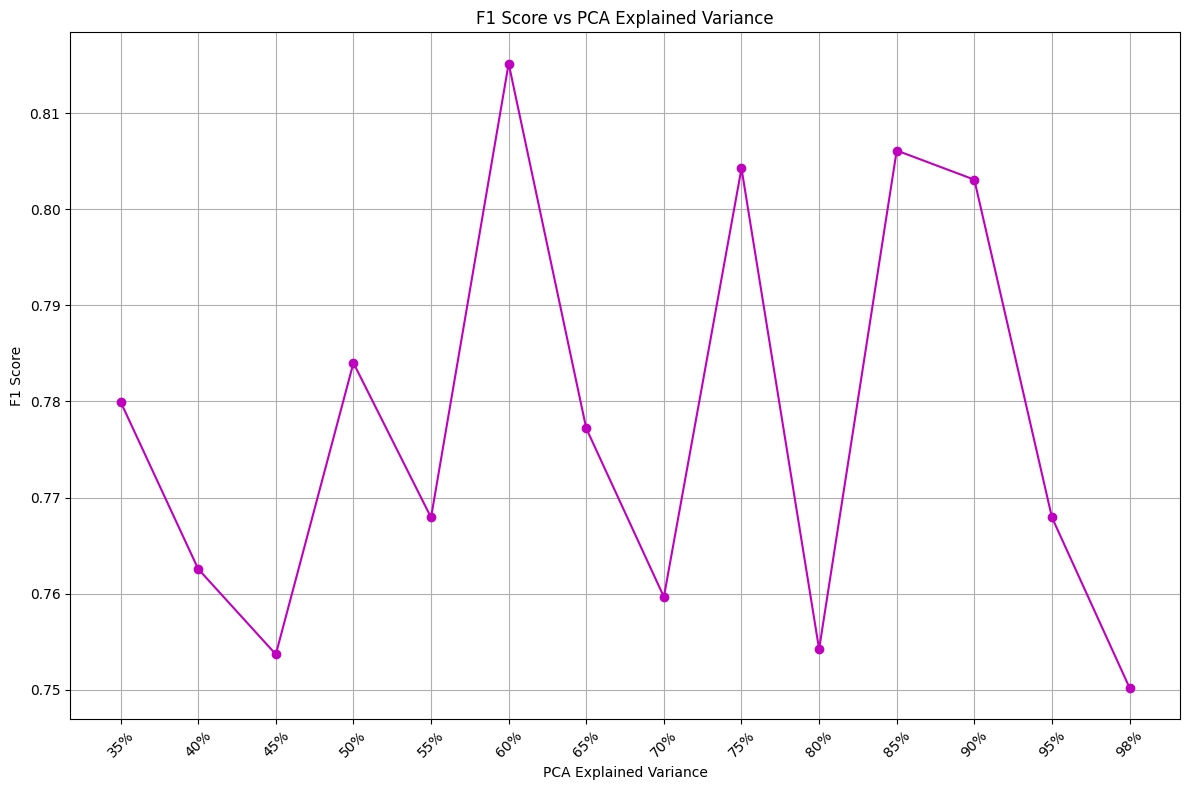

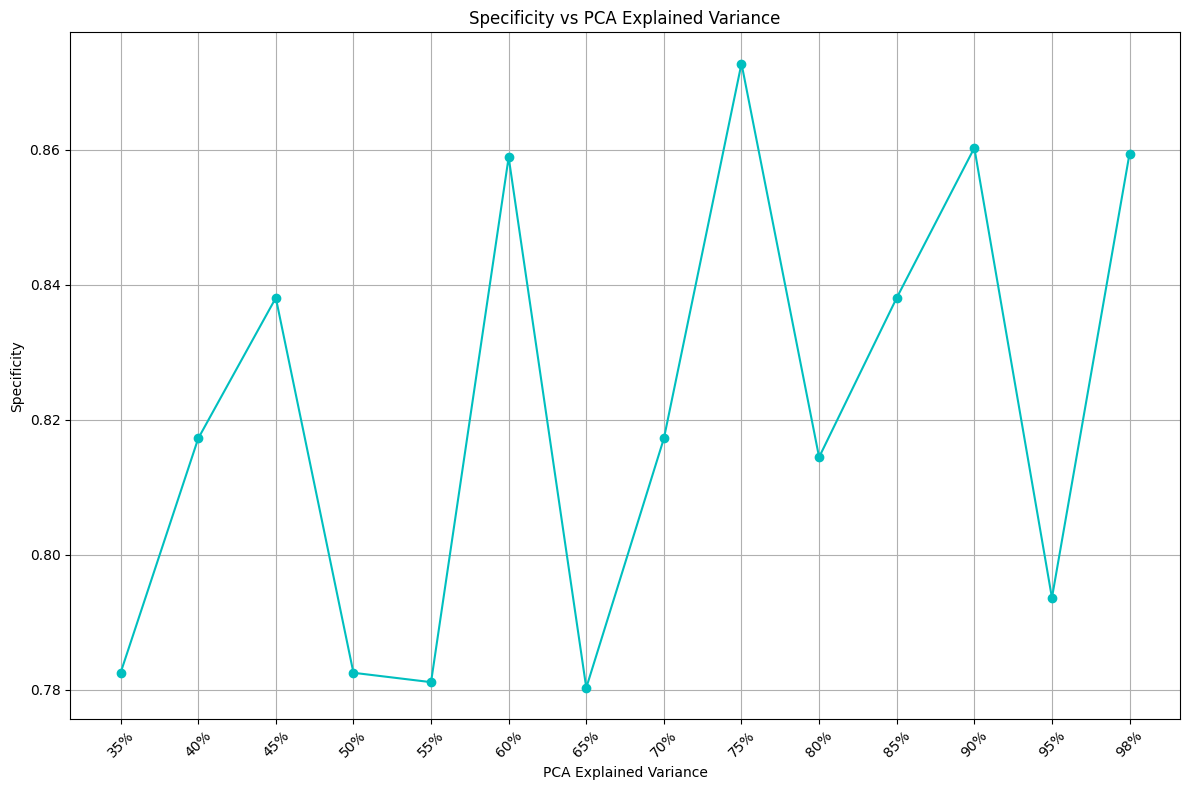

In [59]:
import matplotlib.pyplot as plt

# Convert results dictionary to a DataFrame for easy plotting
results_df = pd.DataFrame(results).T
results_df.index = [f'{variance*100:.0f}%' for variance in pca_variances]

# Plot Accuracy
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['accuracy'], marker='o', linestyle='-', color='b')
plt.title('Accuracy vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['precision'], marker='o', linestyle='-', color='g')
plt.title('Precision vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Precision')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Recall (Sensitivity)
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['recall'], marker='o', linestyle='-', color='r')
plt.title('Recall (Sensitivity) vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Recall (Sensitivity)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['f1'], marker='o', linestyle='-', color='m')
plt.title('F1 Score vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('F1 Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Specificity
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['specificity'], marker='o', linestyle='-', color='c')
plt.title('Specificity vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Specificity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Analysis of PCA Explained Variance: Why 60% and 75% Are Notable Choices

### **Overview:**
From the results and visualizations, it appears that both 60% and 75% explained variance thresholds provide strong performance metrics for the Random Forest classifier. However, each choice has its own implications and trade-offs.

### **60% Explained Variance:**

1. **Balanced Performance**:
   - **Accuracy (0.8224)**: High accuracy indicates that the model performs well overall in classifying instances correctly.
   - **Precision (0.8498)**: High precision shows that the classifier is good at minimizing false positives, which is important in scenarios where false alarms are costly.
   - **Recall (0.7872)**: This reflects a strong ability to capture positive instances without missing too many, which is crucial in applications where missing positive cases could be detrimental.
   - **F1 Score (0.8151)**: A high F1 score suggests a well-balanced trade-off between precision and recall, making this a good choice for scenarios with a balanced need for both metrics.
   - **Specificity (0.8589)**: High specificity indicates the model effectively identifies negative cases, which is important for avoiding false positives.

2. **Reasonable Dimensionality Reduction**:
   - Using 60% explained variance keeps the dimensionality reduction moderate, preserving enough of the original feature space while removing less informative components. This balance helps in maintaining model interpretability and performance.

### **75% Explained Variance:**

1. **Strong Performance Metrics**:
   - **Accuracy (0.8161)**: Comparable to 60%, showing that the model’s overall performance remains high.
   - **Precision (0.8633)**: The highest precision across all PCA thresholds, which implies an excellent ability to avoid false positives.
   - **Recall (0.7615)**: Slightly lower than at 60%, indicating that while precision improves, some positive cases might be missed.
   - **F1 Score (0.8042)**: High but slightly lower than at 60%, suggesting a trade-off where precision gains come at the cost of recall.
   - **Specificity (0.8728)**: Highest specificity, indicating strong performance in identifying negative cases.

2. **Trade-Offs**:
   - **Dimensionality Considerations**: While 75% explained variance improves precision and specificity, it also reduces recall. This trade-off might be acceptable depending on the application, especially if false positives are more costly than missed positives.
   - **Risk of Overfitting**: With more components, there’s a risk of including noise, which can potentially lead to overfitting. It’s essential to ensure that the improved precision does not come at an undue cost to the model's generalizability.

## **Now, we try to repeat this analysis by using the other classifiers**

### Let's start with kNN

In [63]:
# Import necessary libraries
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Drop the 'ID' column to avoid using it as a feature
X = X.drop(columns=['ID'])

# Ensure y is a 1D array
y = y.values.ravel()  # Flatten y if it's a column vector

# Encode the target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the number of splits for K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the PCA variance thresholds
pca_variances = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.98]

# Define the kNN parameters as specified
knn_params = {
    'algorithm': 'auto',
    'leaf_size': 10,
    'metric': 'minkowski',
    'metric_params': None,
    'n_neighbors': 1,
    'p': 1,
    'weights': 'uniform'
}

# Dictionary to store mean scores for each PCA variance
results = {}

###########################################
# Get the total number of features
max_features = min(X.shape[0], X.shape[1])
###########################################

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Scorers for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),  # This is also sensitivity
    'f1': make_scorer(f1_score),
    'specificity': make_scorer(specificity)  # Custom scorer for specificity
}

# Iterate over each PCA variance threshold
for variance in pca_variances:
    # Create a pipeline with StandardScaler, PCA, and KNeighborsClassifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                  # Standardize the data
        ('pca', PCA(n_components=variance)),           # Apply PCA with specified variance
        ('classifier', KNeighborsClassifier(**knn_params))  # kNN classifier
    ])
    
    # Perform cross-validation and compute multiple metrics
    cv_results = cross_validate(pipeline, X, y_encoded, cv=kf, scoring=scoring, return_train_score=False)
    
    # Store the mean scores for each metric
    results[variance] = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'specificity': np.mean(cv_results['test_specificity'])
    }

    ####################################################
    # Fit the PCA to get the number of components
    pca = PCA(n_components=variance)
    pca.fit(StandardScaler().fit_transform(X))
    n_components = pca.n_components_
    ####################################################
    
    # Print the results for the current PCA variance
    print(f"\nPCA with {variance*100:.0f}% explained variance:")
    print(f"  Components: {n_components}/{max_features}")
    print(f"  Accuracy: {results[variance]['accuracy']:.4f}")
    print(f"  Precision: {results[variance]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {results[variance]['recall']:.4f}")
    print(f"  F1 Score: {results[variance]['f1']:.4f}")
    print(f"  Specificity: {results[variance]['specificity']:.4f}")


PCA with 35% explained variance:
  Components: 10/174
  Accuracy: 0.7650
  Precision: 0.8130
  Recall (Sensitivity): 0.6984
  F1 Score: 0.7498
  Specificity: 0.8381

PCA with 40% explained variance:
  Components: 12/174
  Accuracy: 0.7534
  Precision: 0.7874
  Recall (Sensitivity): 0.7089
  F1 Score: 0.7426
  Specificity: 0.8061

PCA with 45% explained variance:
  Components: 15/174
  Accuracy: 0.7588
  Precision: 0.8163
  Recall (Sensitivity): 0.6729
  F1 Score: 0.7342
  Specificity: 0.8506

PCA with 50% explained variance:
  Components: 19/174
  Accuracy: 0.7533
  Precision: 0.8770
  Recall (Sensitivity): 0.6083
  F1 Score: 0.7101
  Specificity: 0.9075

PCA with 55% explained variance:
  Components: 23/174
  Accuracy: 0.7477
  Precision: 0.8854
  Recall (Sensitivity): 0.5873
  F1 Score: 0.6922
  Specificity: 0.9186

PCA with 60% explained variance:
  Components: 28/174
  Accuracy: 0.7538
  Precision: 0.9059
  Recall (Sensitivity): 0.5778
  F1 Score: 0.6948
  Specificity: 0.9408

PCA

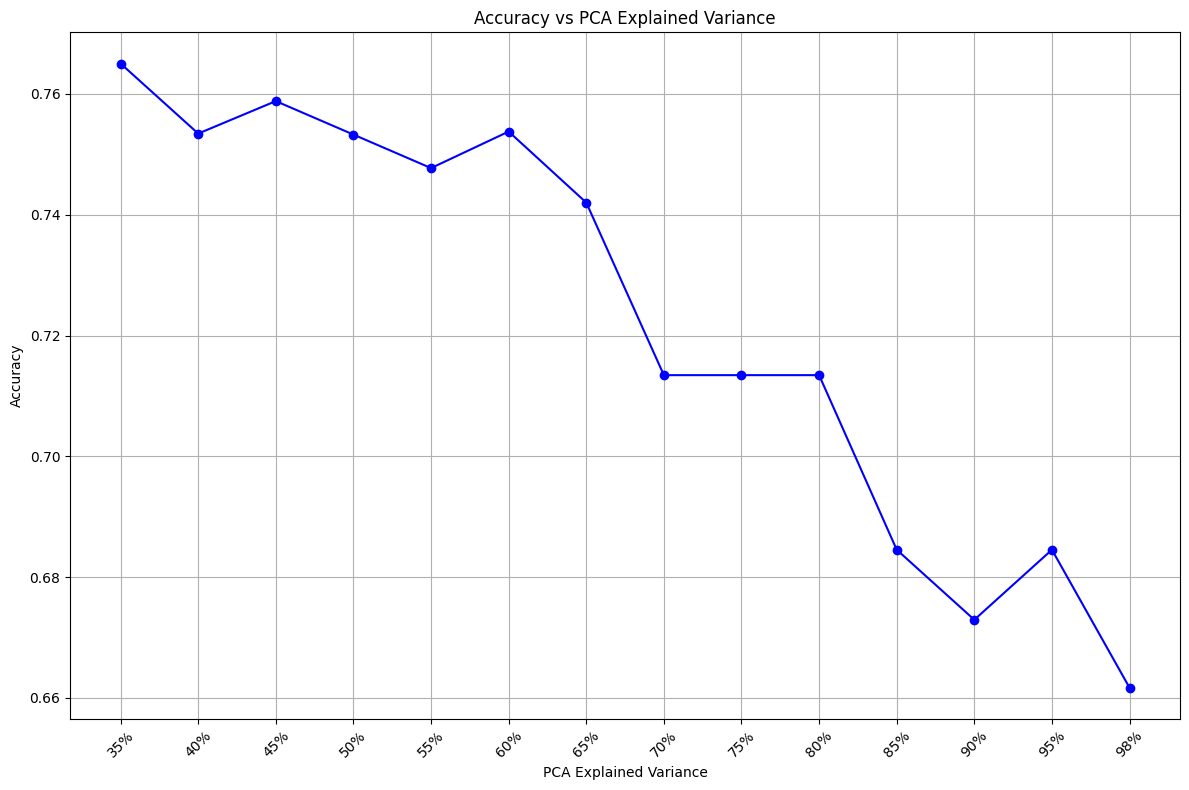

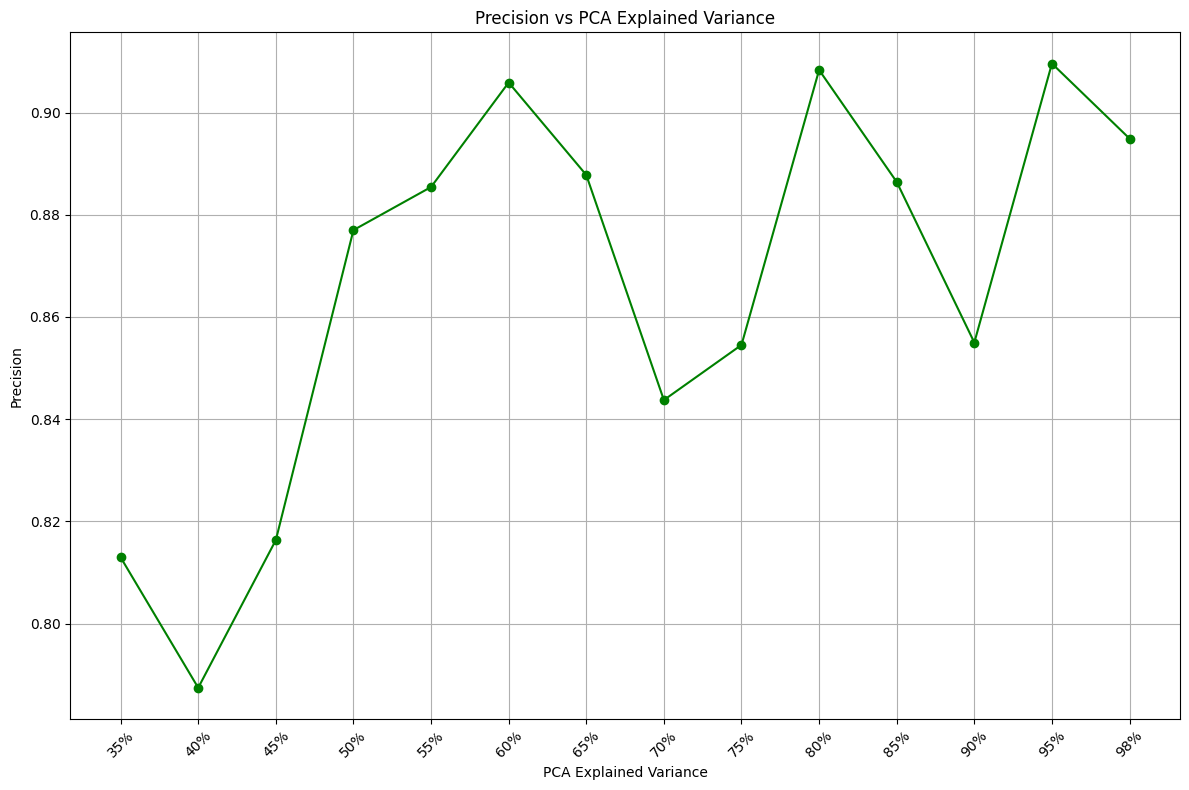

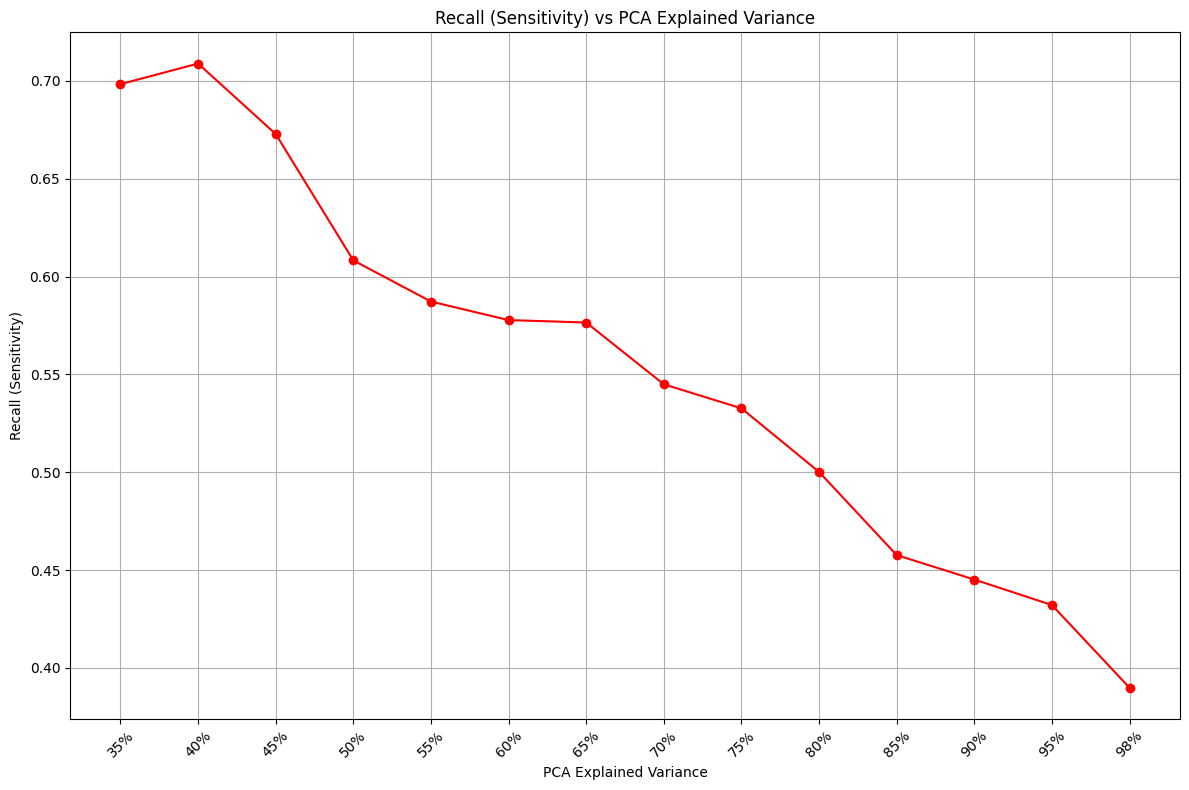

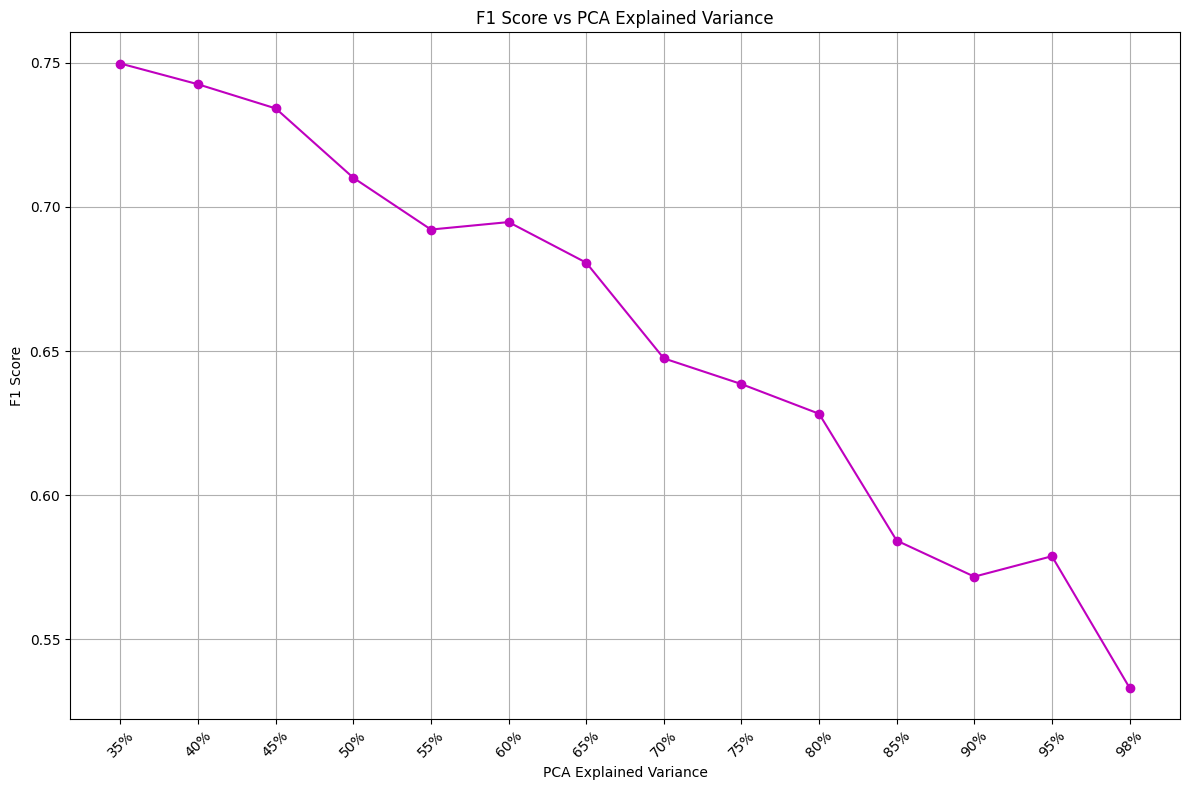

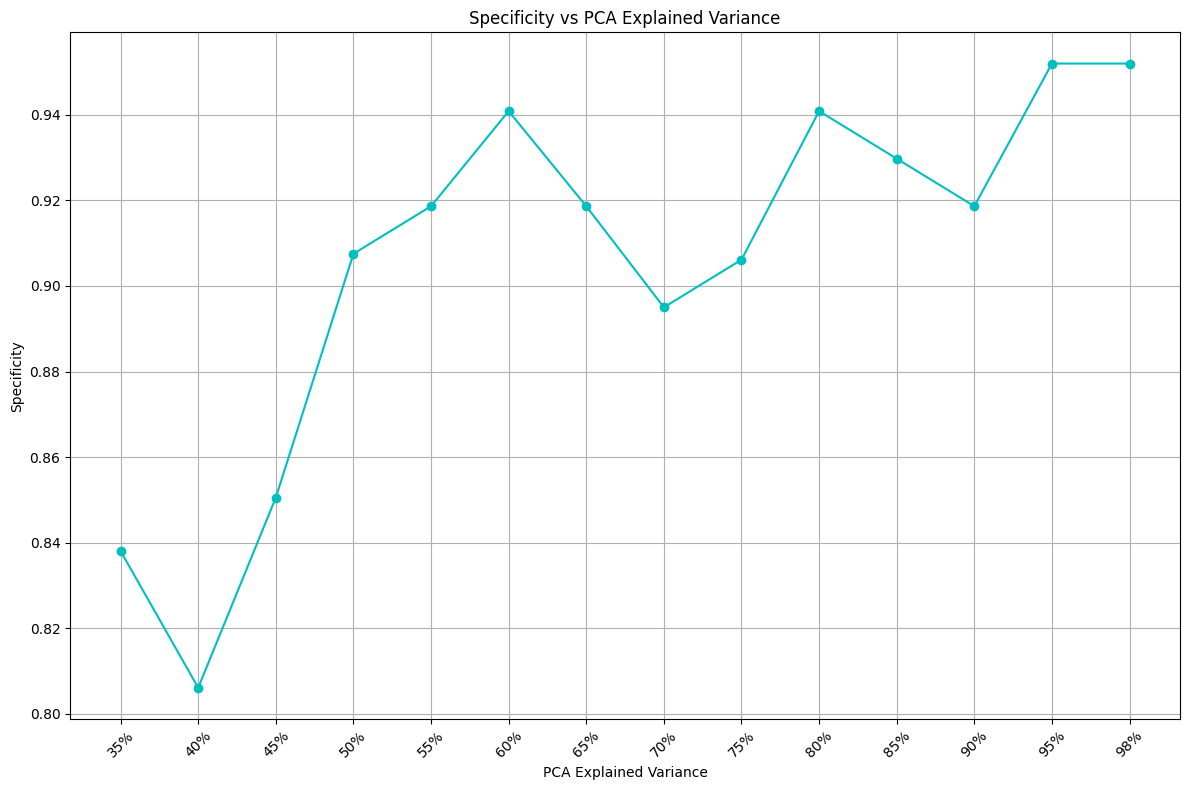

In [32]:
import matplotlib.pyplot as plt

# Convert results dictionary to a DataFrame for easy plotting
results_df = pd.DataFrame(results).T
results_df.index = [f'{variance*100:.0f}%' for variance in pca_variances]

# Plot Accuracy
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['accuracy'], marker='o', linestyle='-', color='b')
plt.title('Accuracy vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['precision'], marker='o', linestyle='-', color='g')
plt.title('Precision vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Precision')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Recall (Sensitivity)
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['recall'], marker='o', linestyle='-', color='r')
plt.title('Recall (Sensitivity) vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Recall (Sensitivity)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['f1'], marker='o', linestyle='-', color='m')
plt.title('F1 Score vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('F1 Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Specificity
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['specificity'], marker='o', linestyle='-', color='c')
plt.title('Specificity vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Specificity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The optimal variance retention appears to be around 35%-50%, where the classifier maintains a good balance between accuracy, precision, recall, and specificity.

As PCA variance increases beyond 50%, precision tends to improve while recall and accuracy generally decline. This suggests a trade-off where the classifier becomes more conservative and less effective in capturing all positive instances.
Overfitting/Underfitting:

With very high variance retention (85%-98%), the model might be overfitting to the data or including too many irrelevant components, leading to poorer overall performance.

### Decision tree

In [64]:
# Import necessary libraries
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Drop the 'ID' column to avoid using it as a feature
X = X.drop(columns=['ID'])

# Ensure y is a 1D array
y = y.values.ravel()  # Flatten y if it's a column vector

# Encode the target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the number of splits for K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the PCA variance thresholds
pca_variances = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.98]

# Define the Decision Tree parameters with increased flexibility
decision_tree_params = {
    'criterion': 'gini',
    'max_depth': 10,  # Increased depth
    'max_leaf_nodes': 50,  # Increased number of leaf nodes
    'min_samples_leaf': 1,  # Allow fewer samples per leaf
    'min_samples_split': 2,  # Allow splitting with fewer samples
    'random_state': 42
}

# Dictionary to store mean scores for each PCA variance
results = {}

###########################################
# Get the total number of features
max_features = min(X.shape[0], X.shape[1])
###########################################

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Scorers for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),  # This is also sensitivity
    'f1': make_scorer(f1_score),
    'specificity': make_scorer(specificity)  # Custom scorer for specificity
}

# Iterate over each PCA variance threshold
for variance in pca_variances:
    # Create a pipeline with StandardScaler, PCA, and DecisionTreeClassifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                  # Standardize the data
        ('pca', PCA(n_components=variance)),           # Apply PCA with specified variance
        ('classifier', DecisionTreeClassifier(**decision_tree_params))  # Decision Tree classifier
    ])
    
    # Perform cross-validation and compute multiple metrics
    cv_results = cross_validate(pipeline, X, y_encoded, cv=kf, scoring=scoring, return_train_score=False)
    
    # Store the mean scores for each metric
    results[variance] = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'specificity': np.mean(cv_results['test_specificity'])
    }

    ####################################################
    # Fit the PCA to get the number of components
    pca = PCA(n_components=variance)
    pca.fit(StandardScaler().fit_transform(X))
    n_components = pca.n_components_
    ####################################################
    
    # Print the results for the current PCA variance
    print(f"\nPCA with {variance*100:.0f}% explained variance:")
    print(f"  Components: {n_components}/{max_features}")
    print(f"  Accuracy: {results[variance]['accuracy']:.4f}")
    print(f"  Precision: {results[variance]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {results[variance]['recall']:.4f}")
    print(f"  F1 Score: {results[variance]['f1']:.4f}")
    print(f"  Specificity: {results[variance]['specificity']:.4f}")


PCA with 35% explained variance:
  Components: 10/174
  Accuracy: 0.8101
  Precision: 0.8038
  Recall (Sensitivity): 0.8305
  F1 Score: 0.8126
  Specificity: 0.7914

PCA with 40% explained variance:
  Components: 12/174
  Accuracy: 0.8328
  Precision: 0.8197
  Recall (Sensitivity): 0.8626
  F1 Score: 0.8393
  Specificity: 0.8025

PCA with 45% explained variance:
  Components: 15/174
  Accuracy: 0.8331
  Precision: 0.8339
  Recall (Sensitivity): 0.8411
  F1 Score: 0.8347
  Specificity: 0.8247

PCA with 50% explained variance:
  Components: 19/174
  Accuracy: 0.8331
  Precision: 0.8459
  Recall (Sensitivity): 0.8281
  F1 Score: 0.8286
  Specificity: 0.8358

PCA with 55% explained variance:
  Components: 23/174
  Accuracy: 0.8217
  Precision: 0.8180
  Recall (Sensitivity): 0.8273
  F1 Score: 0.8215
  Specificity: 0.8122

PCA with 60% explained variance:
  Components: 28/174
  Accuracy: 0.8103
  Precision: 0.8072
  Recall (Sensitivity): 0.8168
  F1 Score: 0.8119
  Specificity: 0.8025

PCA

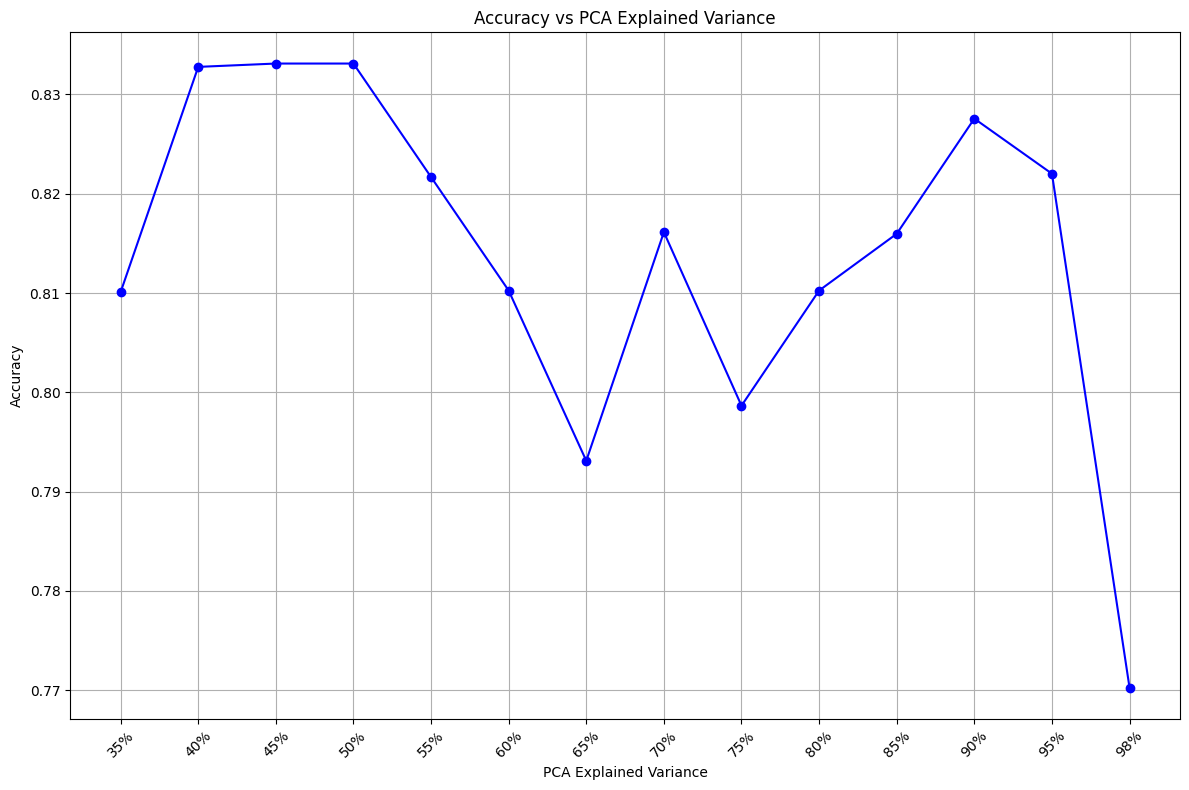

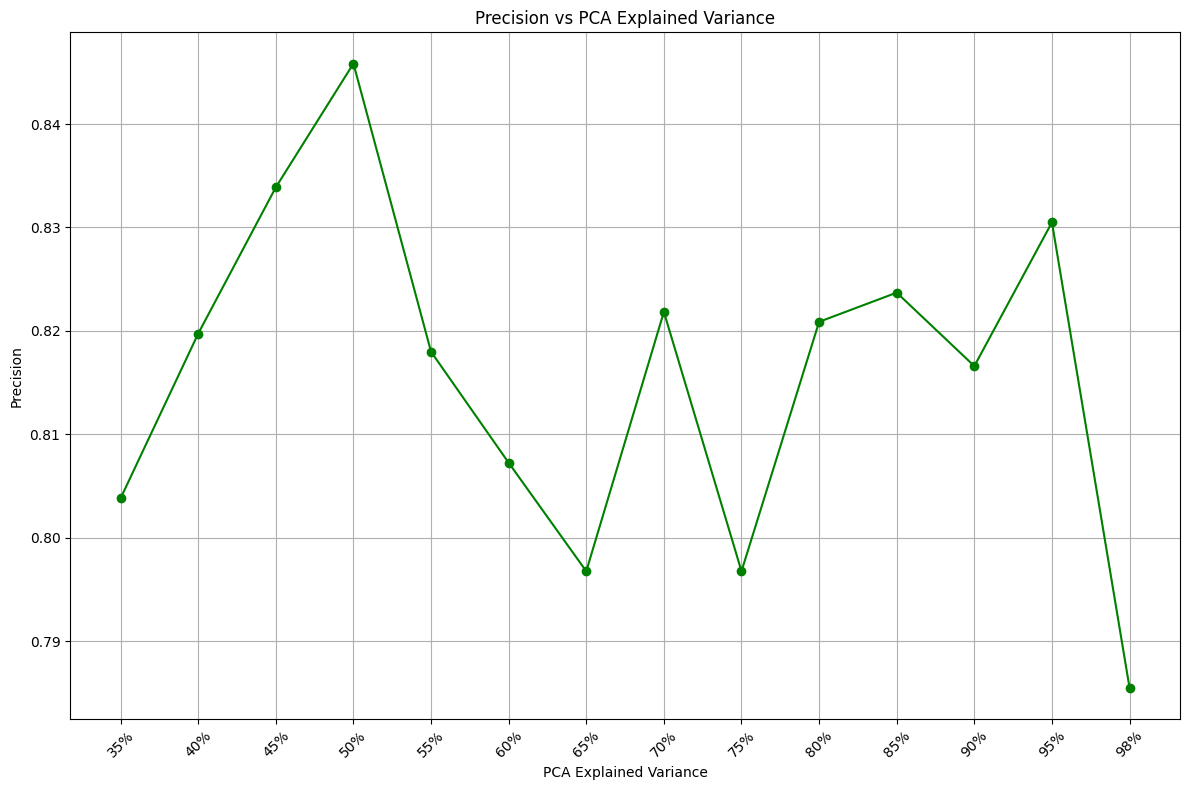

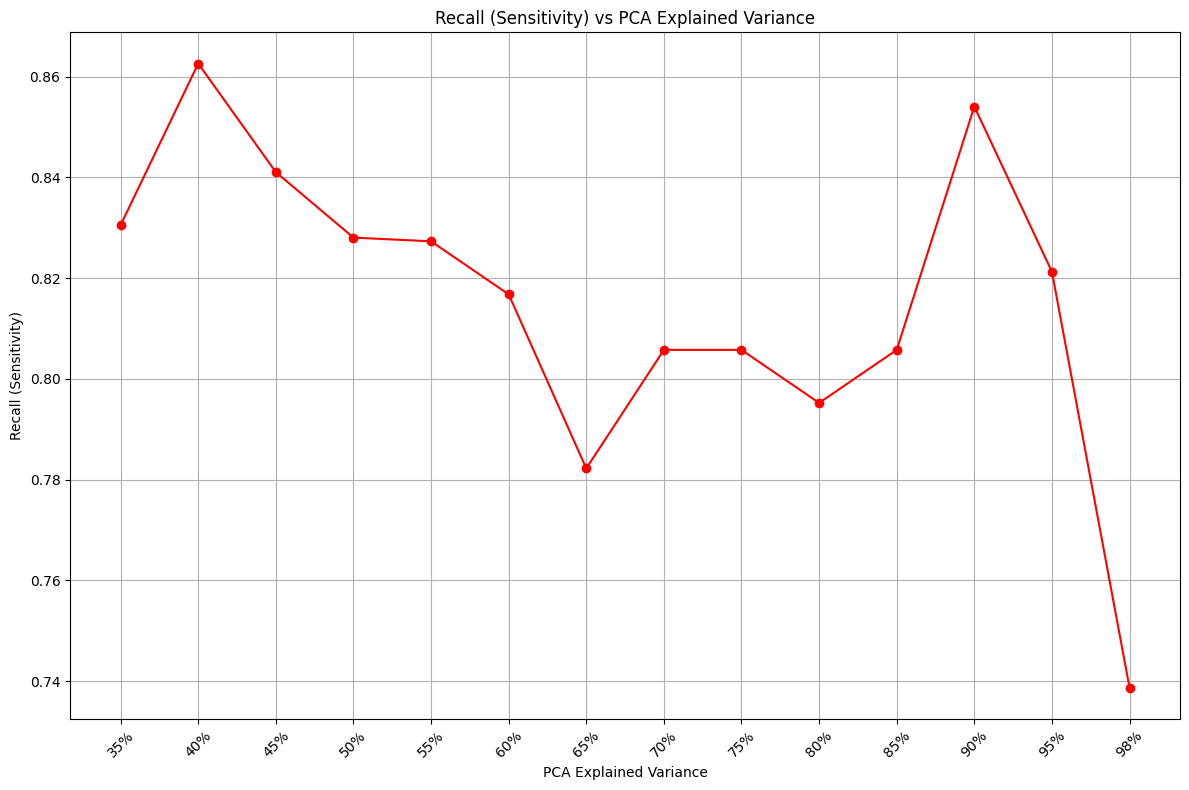

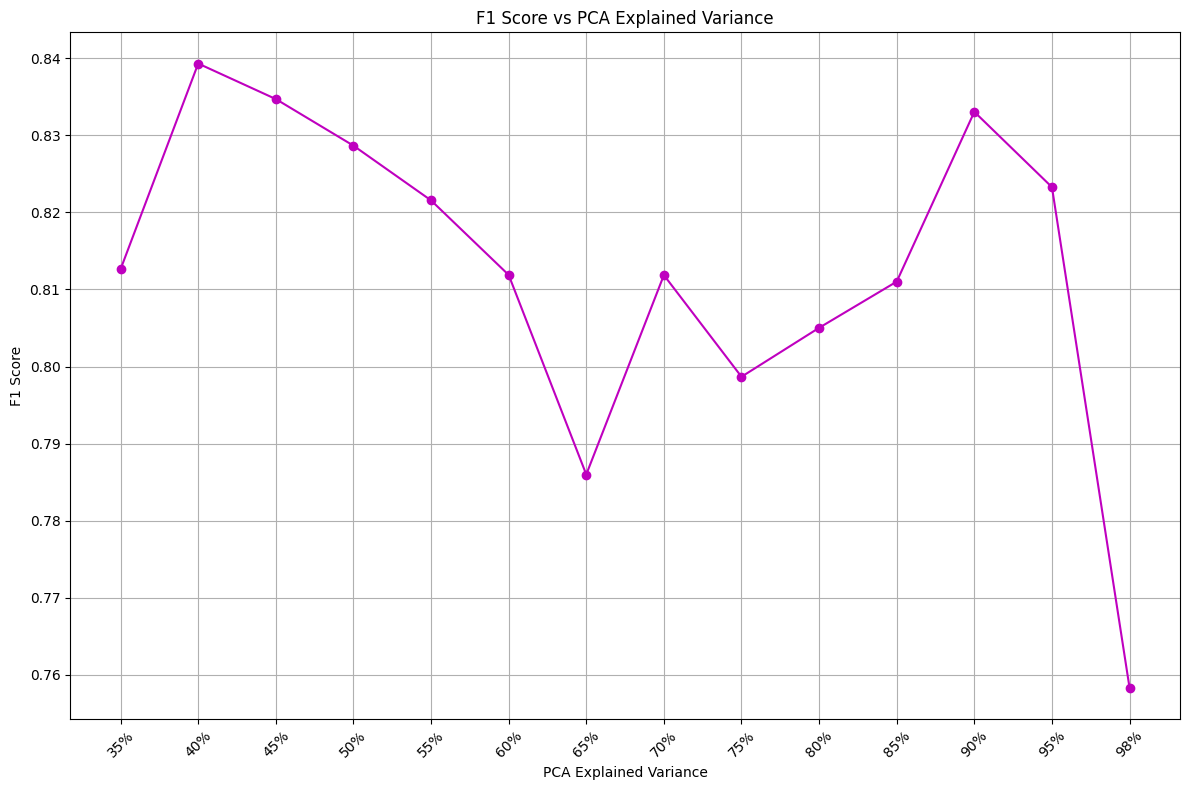

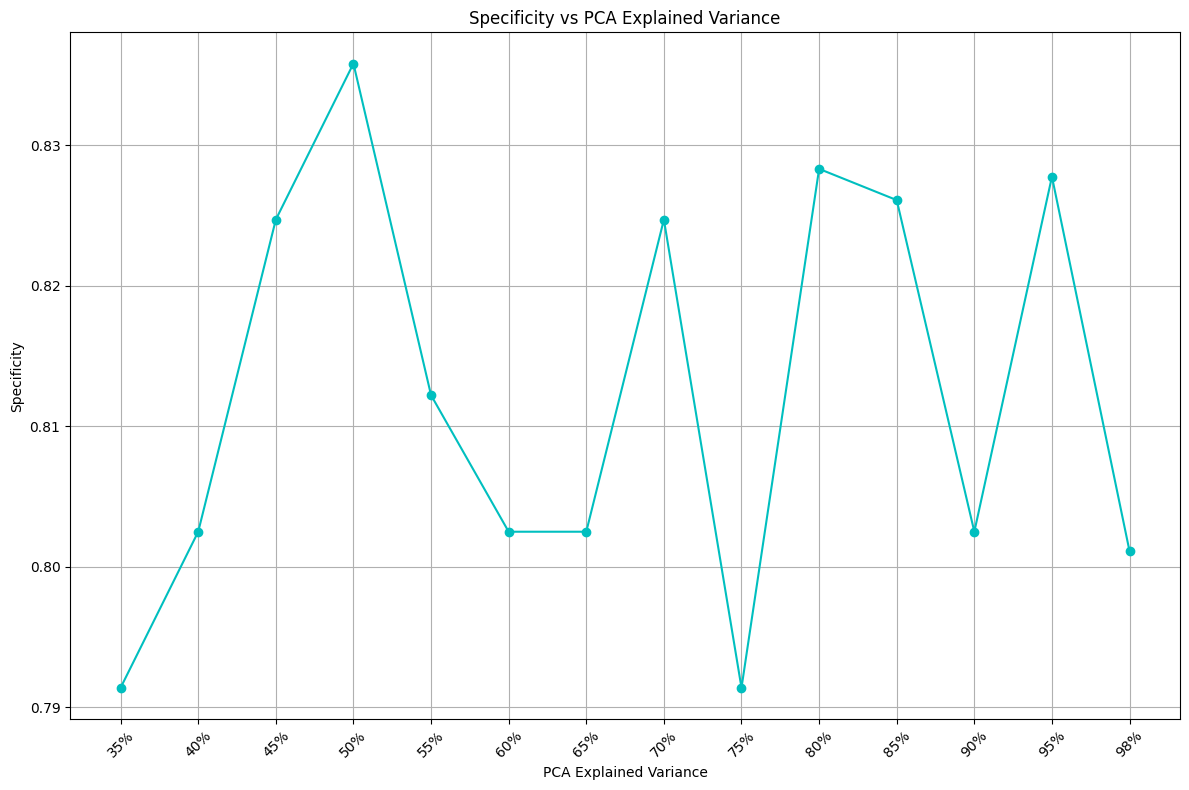

In [40]:
import matplotlib.pyplot as plt

# Convert results dictionary to a DataFrame for easy plotting
results_df = pd.DataFrame(results).T
results_df.index = [f'{variance*100:.0f}%' for variance in pca_variances]

# Plot Accuracy
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['accuracy'], marker='o', linestyle='-', color='b')
plt.title('Accuracy vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['precision'], marker='o', linestyle='-', color='g')
plt.title('Precision vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Precision')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Recall (Sensitivity)
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['recall'], marker='o', linestyle='-', color='r')
plt.title('Recall (Sensitivity) vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Recall (Sensitivity)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['f1'], marker='o', linestyle='-', color='m')
plt.title('F1 Score vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('F1 Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Specificity
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['specificity'], marker='o', linestyle='-', color='c')
plt.title('Specificity vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Specificity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


For a balanced performance (considering accuracy, precision, recall, and F1 Score): PCA with 45% Explained Variance seems to be a strong choice.
For the highest precision (with a slight trade-off in recall): PCA with 50% Explained Variance is preferable.

## Gaussian Naive Bayes

In [65]:
# Import necessary libraries
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Drop the 'ID' column to avoid using it as a feature
X = X.drop(columns=['ID'])

# Ensure y is a 1D array
y = y.values.ravel()  # Flatten y if it's a column vector

# Encode the target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the number of splits for K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the PCA variance thresholds
pca_variances = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.98]

# Define the Gaussian Naive Bayes parameters as specified
gnb_params = {
    'var_smoothing': 1e-09
}

# Dictionary to store mean scores for each PCA variance
results = {}

###########################################
# Get the total number of features
max_features = min(X.shape[0], X.shape[1])
###########################################

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Scorers for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),  # This is also sensitivity
    'f1': make_scorer(f1_score),
    'specificity': make_scorer(specificity)  # Custom scorer for specificity
}

# Iterate over each PCA variance threshold
for variance in pca_variances:
    # Create a pipeline with StandardScaler, PCA, and GaussianNB
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                  # Standardize the data
        ('pca', PCA(n_components=variance)),           # Apply PCA with specified variance
        ('classifier', GaussianNB(**gnb_params))  # Gaussian Naive Bayes classifier
    ])
    
    # Perform cross-validation and compute multiple metrics
    cv_results = cross_validate(pipeline, X, y_encoded, cv=kf, scoring=scoring, return_train_score=False)
    
    # Store the mean scores for each metric
    results[variance] = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'specificity': np.mean(cv_results['test_specificity'])
    }

    ####################################################
    # Fit the PCA to get the number of components
    pca = PCA(n_components=variance)
    pca.fit(StandardScaler().fit_transform(X))
    n_components = pca.n_components_
    ####################################################
    
    # Print the results for the current PCA variance
    print(f"\nPCA with {variance*100:.0f}% explained variance:")
    print(f"  Components: {n_components}/{max_features}")
    print(f"  Accuracy: {results[variance]['accuracy']:.4f}")
    print(f"  Precision: {results[variance]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {results[variance]['recall']:.4f}")
    print(f"  F1 Score: {results[variance]['f1']:.4f}")
    print(f"  Specificity: {results[variance]['specificity']:.4f}")


PCA with 35% explained variance:
  Components: 10/174
  Accuracy: 0.7531
  Precision: 0.8486
  Recall (Sensitivity): 0.6251
  F1 Score: 0.7106
  Specificity: 0.8825

PCA with 40% explained variance:
  Components: 12/174
  Accuracy: 0.7188
  Precision: 0.8117
  Recall (Sensitivity): 0.5810
  F1 Score: 0.6627
  Specificity: 0.8581

PCA with 45% explained variance:
  Components: 15/174
  Accuracy: 0.7363
  Precision: 0.8495
  Recall (Sensitivity): 0.5815
  F1 Score: 0.6781
  Specificity: 0.8936

PCA with 50% explained variance:
  Components: 19/174
  Accuracy: 0.7249
  Precision: 0.8563
  Recall (Sensitivity): 0.5510
  F1 Score: 0.6628
  Specificity: 0.9061

PCA with 55% explained variance:
  Components: 23/174
  Accuracy: 0.7192
  Precision: 0.8372
  Recall (Sensitivity): 0.5523
  F1 Score: 0.6627
  Specificity: 0.8950

PCA with 60% explained variance:
  Components: 28/174
  Accuracy: 0.7020
  Precision: 0.8346
  Recall (Sensitivity): 0.5064
  F1 Score: 0.6240
  Specificity: 0.9061

PCA

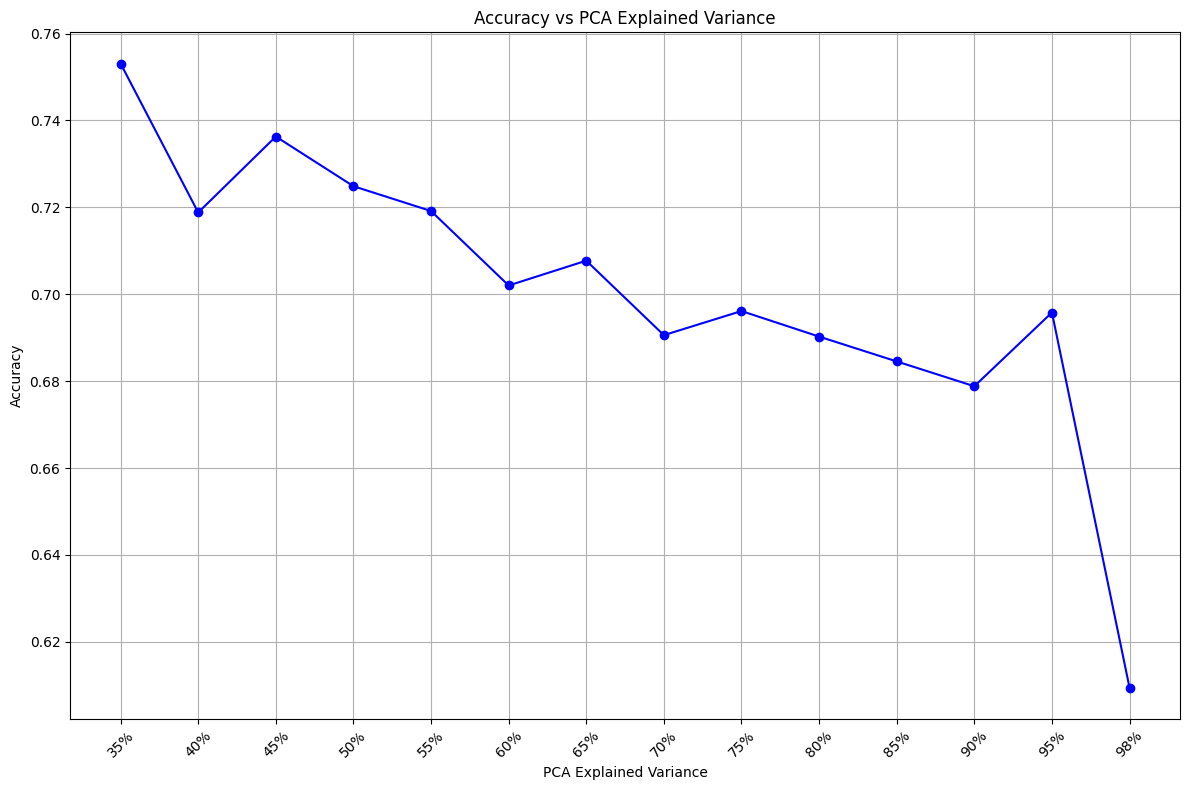

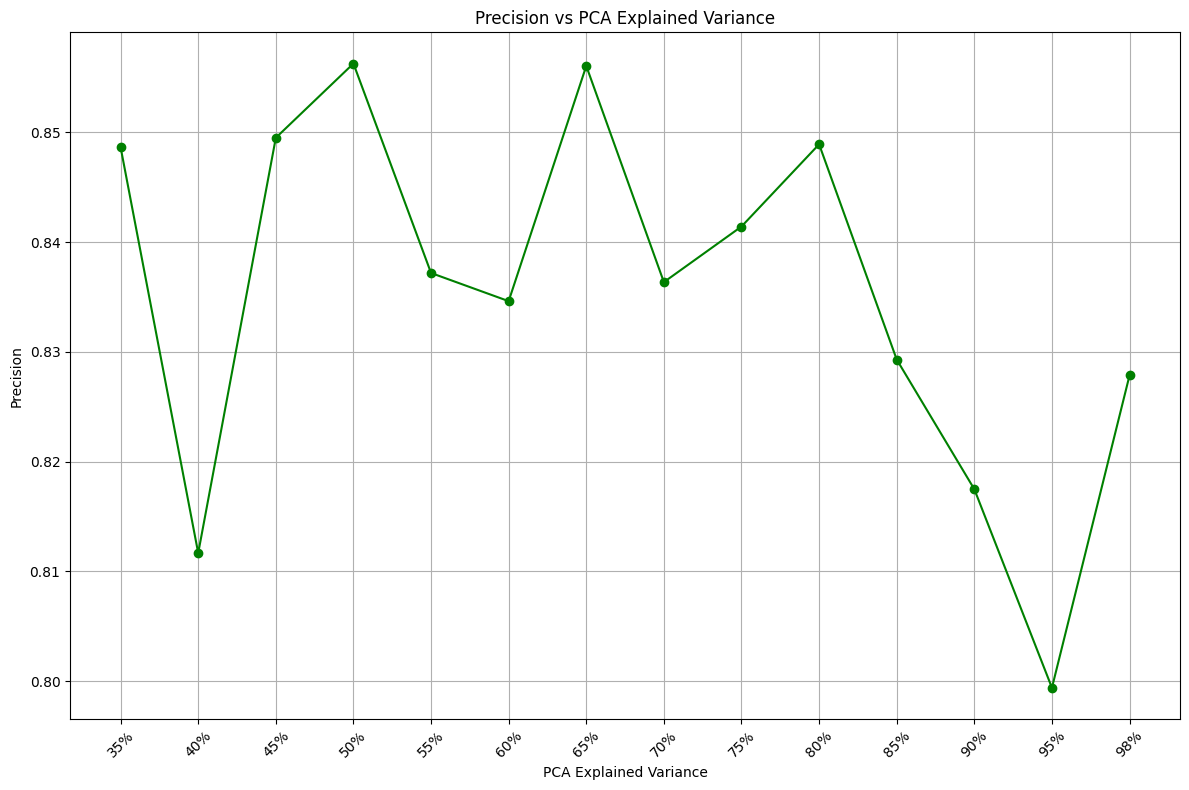

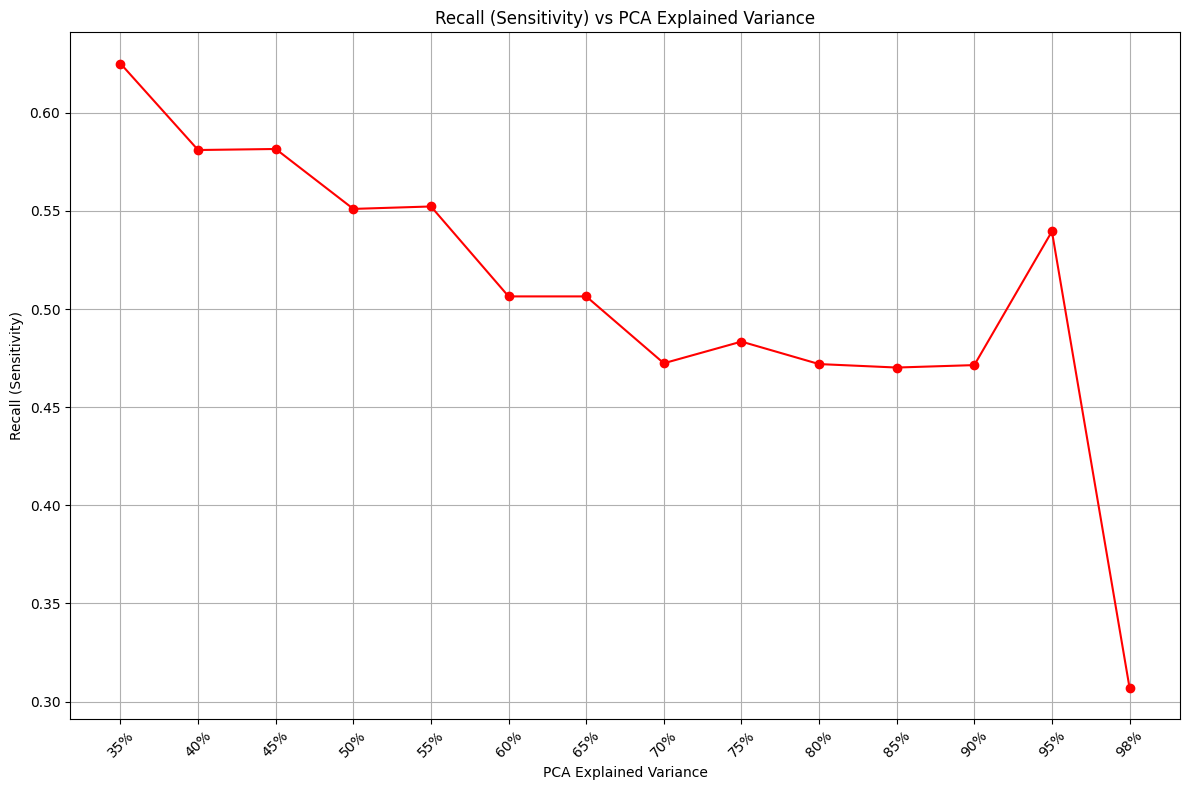

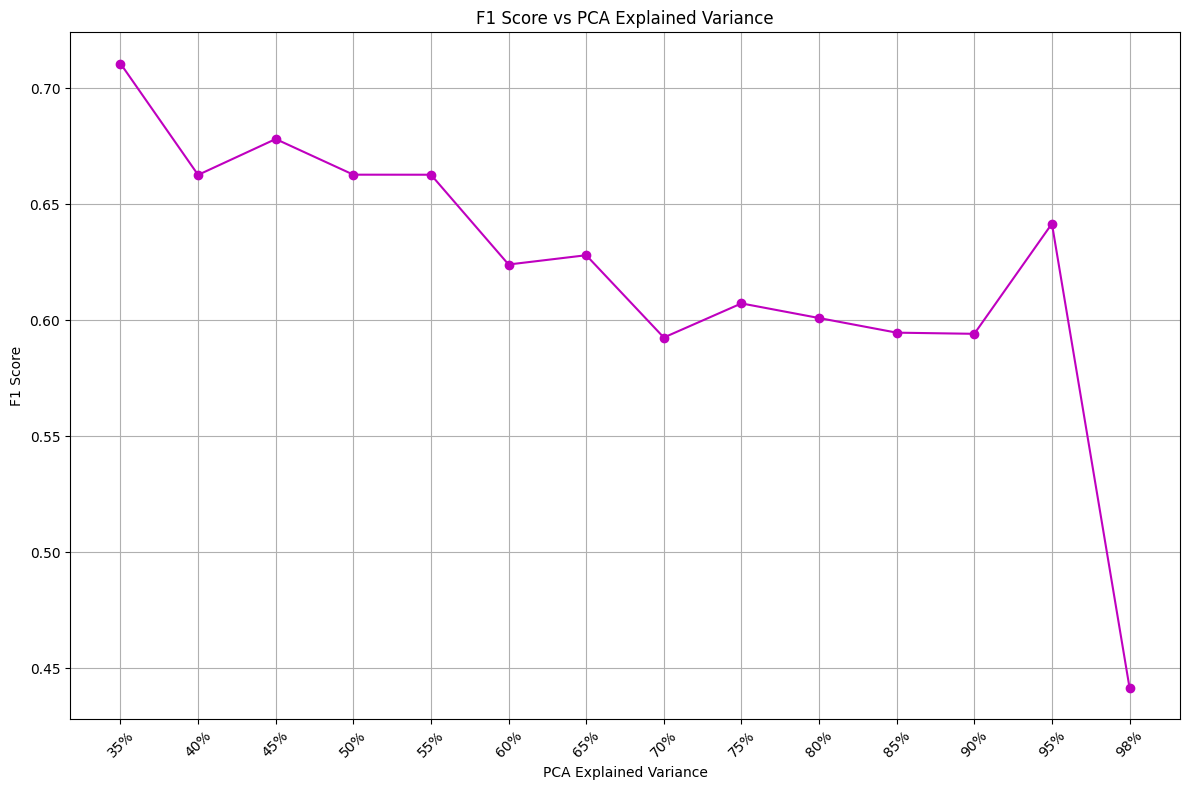

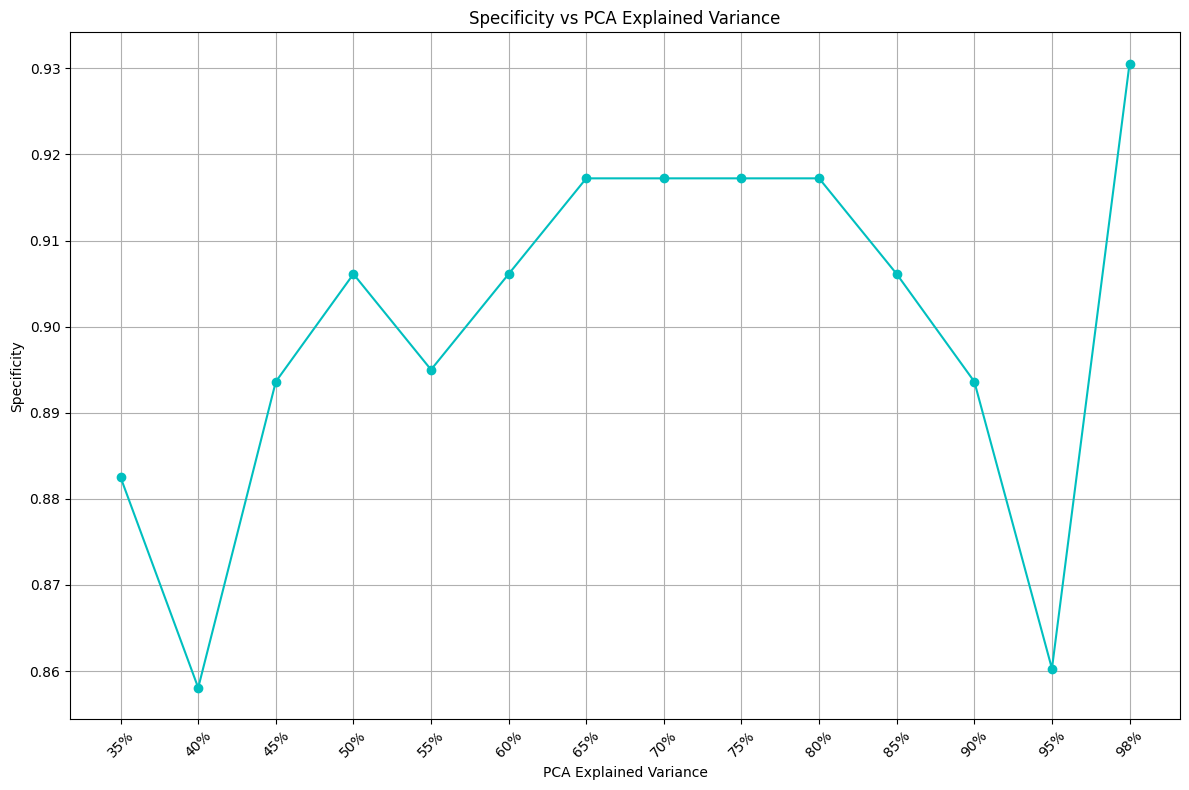

In [57]:
import matplotlib.pyplot as plt

# Convert results dictionary to a DataFrame for easy plotting
results_df = pd.DataFrame(results).T
results_df.index = [f'{variance*100:.0f}%' for variance in pca_variances]

# Plot Accuracy
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['accuracy'], marker='o', linestyle='-', color='b')
plt.title('Accuracy vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['precision'], marker='o', linestyle='-', color='g')
plt.title('Precision vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Precision')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Recall (Sensitivity)
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['recall'], marker='o', linestyle='-', color='r')
plt.title('Recall (Sensitivity) vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Recall (Sensitivity)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['f1'], marker='o', linestyle='-', color='m')
plt.title('F1 Score vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('F1 Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Specificity
plt.figure(figsize=(12, 8))
plt.plot(results_df.index, results_df['specificity'], marker='o', linestyle='-', color='c')
plt.title('Specificity vs PCA Explained Variance')
plt.xlabel('PCA Explained Variance')
plt.ylabel('Specificity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### It looks like projecting into these principal components doesn't work well for Gaussian Naive Bayes.